In [3]:
# =============================================================================
# FRAUD DETECTION - MODEL BUILDING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, 
    average_precision_score, roc_curve
)
import xgboost as xgb
import lightgbm as lgb

print("=" * 70)
print("🤖 FRAUD DETECTION - MODEL BUILDING")
print("=" * 70)

# -----------------------------------------------------------------------------
# LOAD ENGINEERED DATA
# -----------------------------------------------------------------------------
print("\n📁 Loading engineered dataset...")

DATA_PATH = Path(r"C:\Users\aadik\Desktop\FraudDetection\data")
df = pd.read_pickle(DATA_PATH / 'df_engineered.pkl')

print(f"   Shape: {df.shape}")
print(f"   Fraud rate: {df['isFraud'].mean()*100:.2f}%")

# -----------------------------------------------------------------------------
# SELECT FEATURES FOR MODELING
# -----------------------------------------------------------------------------
print("\n🎯 Selecting features...")

# Columns to DROP (not useful for modeling)
drop_cols = [
    'TransactionID',      # Just an ID, not predictive
    'TransactionDT',      # We extracted time features from this
    'amount_bin',         # Categorical — we'll use amount_log instead
]

# Identify categorical columns that need special handling
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"   Categorical columns to handle: {len(categorical_cols)}")

# For now, we'll drop high-cardinality categoricals and keep our engineered features
# High cardinality = too many unique values (like DeviceInfo with 1000+ values)
high_cardinality_cols = []
for col in categorical_cols:
    if col in df.columns:
        n_unique = df[col].nunique()
        if n_unique > 50:  # More than 50 unique values
            high_cardinality_cols.append(col)
            
print(f"   High-cardinality columns to drop: {len(high_cardinality_cols)}")

# Combine all columns to drop
all_drop_cols = drop_cols + categorical_cols  # Drop all categoricals for now
all_drop_cols = [c for c in all_drop_cols if c in df.columns]

# Create feature matrix
X = df.drop(columns=['isFraud'] + all_drop_cols, errors='ignore')
y = df['isFraud']

print(f"\n   Features selected: {X.shape[1]}")
print(f"   Samples: {X.shape[0]:,}")

# -----------------------------------------------------------------------------
# HANDLE MISSING VALUES
# -----------------------------------------------------------------------------
print("\n🔧 Handling missing values...")

# Check missing values
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
cols_with_missing = missing_pct[missing_pct > 0]
print(f"   Columns with missing values: {len(cols_with_missing)}")

# Fill missing values with median (safe for numerical data)
# XGBoost/LightGBM can handle NaN, but let's fill for consistency
X = X.fillna(X.median())

# Verify no missing values remain
remaining_missing = X.isnull().sum().sum()
print(f"   Missing values after filling: {remaining_missing}")

# -----------------------------------------------------------------------------
# VERIFY DATA IS READY
# -----------------------------------------------------------------------------
print("\n✅ Data preparation complete!")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")

🤖 FRAUD DETECTION - MODEL BUILDING

📁 Loading engineered dataset...
   Shape: (590540, 461)
   Fraud rate: 3.50%

🎯 Selecting features...
   Categorical columns to handle: 32
   High-cardinality columns to drop: 6

   Features selected: 426
   Samples: 590,540

🔧 Handling missing values...
   Columns with missing values: 384
   Missing values after filling: 0

✅ Data preparation complete!
   Feature matrix shape: (590540, 426)
   Target shape: (590540,)
   Target distribution: {0: 569877, 1: 20663}


In [4]:
# =============================================================================
# STEP 2: SPLIT DATA INTO TRAIN / VALIDATION / TEST
# =============================================================================

print("\n" + "=" * 70)
print("📊 STEP 2: TRAIN/TEST SPLIT")
print("=" * 70)

# -----------------------------------------------------------------------------
# WHY SPLIT DATA?
# -----------------------------------------------------------------------------
# We need separate data to:
#   1. TRAIN the model (learn patterns)
#   2. VALIDATE during training (tune parameters)
#   3. TEST at the end (final unbiased evaluation)
#
# If we test on training data, the model just "memorizes" — not useful!

# -----------------------------------------------------------------------------
# SPLIT: 70% TRAIN, 15% VALIDATION, 15% TEST
# -----------------------------------------------------------------------------

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30,           # 30% for validation + test
    random_state=42,          # Reproducible results
    stratify=y                # Keep same fraud ratio in all sets
)

# Second split: Split the 30% into 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,           # 50% of 30% = 15% each
    random_state=42,
    stratify=y_temp
)

# Clean up temp variable
del X_temp, y_temp

# -----------------------------------------------------------------------------
# VERIFY SPLITS
# -----------------------------------------------------------------------------
print("\n📊 Dataset splits:")
print(f"\n   {'Set':<12} {'Samples':>12} {'Fraud':>10} {'Fraud %':>10}")
print(f"   {'-'*46}")

for name, X_set, y_set in [('Train', X_train, y_train), 
                            ('Validation', X_val, y_val), 
                            ('Test', X_test, y_test)]:
    n_samples = len(y_set)
    n_fraud = y_set.sum()
    fraud_pct = y_set.mean() * 100
    print(f"   {name:<12} {n_samples:>12,} {n_fraud:>10,} {fraud_pct:>9.2f}%")

print(f"\n   Total samples: {len(y_train) + len(y_val) + len(y_test):,}")
print(f"\n   ✅ Stratified split complete — fraud ratio preserved in all sets!")


📊 STEP 2: TRAIN/TEST SPLIT

📊 Dataset splits:

   Set               Samples      Fraud    Fraud %
   ----------------------------------------------
   Train             413,378     14,464      3.50%
   Validation         88,581      3,100      3.50%
   Test               88,581      3,099      3.50%

   Total samples: 590,540

   ✅ Stratified split complete — fraud ratio preserved in all sets!


In [5]:
# =============================================================================
# STEP 3: FEATURE SCALING
# =============================================================================
print("\n" + "=" * 70)
print("⚖️  STEP 3: FEATURE SCALING")
print("=" * 70)

from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# INITIALIZE THE SCALER
# -----------------------------------------------------------------------------
# StandardScaler will transform features to have mean=0 and std=1
# This helps models that use gradient descent (Logistic Regression, Neural Nets)

scaler = StandardScaler()

# -----------------------------------------------------------------------------
# FIT ON TRAINING DATA ONLY, THEN TRANSFORM ALL SETS
# -----------------------------------------------------------------------------
# fit_transform: Calculate mean & std from X_train, then scale X_train
# transform: Use the SAME mean & std (from train) to scale val and test
#
# WHY? Prevents data leakage. Test set must be treated as "unseen future data"

print("\n📐 Scaling features...")
print(f"   Features to scale: {X_train.shape[1]}")

X_train_scaled = scaler.fit_transform(X_train)  # Fit + Transform
X_val_scaled = scaler.transform(X_val)          # Transform only (using train stats)
X_test_scaled = scaler.transform(X_test)        # Transform only (using train stats)

# -----------------------------------------------------------------------------
# VERIFY SCALING WORKED
# -----------------------------------------------------------------------------
# After scaling, training data should have mean ≈ 0 and std ≈ 1

print("\n📊 Verification (Training Set After Scaling):")
print(f"   Mean of features:  {X_train_scaled.mean():.6f}  (should be ≈ 0)")
print(f"   Std of features:   {X_train_scaled.std():.6f}   (should be ≈ 1)")

# Show before/after for a sample feature
sample_feature_idx = 0  # First feature
sample_feature_name = X_train.columns[sample_feature_idx]

print(f"\n📈 Example — Feature '{sample_feature_name}':")
print(f"   Before scaling: min={X_train.iloc[:, sample_feature_idx].min():.2f}, "
      f"max={X_train.iloc[:, sample_feature_idx].max():.2f}, "
      f"mean={X_train.iloc[:, sample_feature_idx].mean():.2f}")
print(f"   After scaling:  min={X_train_scaled[:, sample_feature_idx].min():.2f}, "
      f"max={X_train_scaled[:, sample_feature_idx].max():.2f}, "
      f"mean={X_train_scaled[:, sample_feature_idx].mean():.6f}")

print("\n   ✅ Feature scaling complete!")
print("   ✅ Same scaling parameters applied to train, validation, and test sets")


⚖️  STEP 3: FEATURE SCALING

📐 Scaling features...
   Features to scale: 426

📊 Verification (Training Set After Scaling):
   Mean of features:  -0.000000  (should be ≈ 0)
   Std of features:   1.000000   (should be ≈ 1)

📈 Example — Feature 'TransactionAmt':
   Before scaling: min=0.25, max=31937.39, mean=134.97
   After scaling:  min=-0.56, max=131.78, mean=-0.000000

   ✅ Feature scaling complete!
   ✅ Same scaling parameters applied to train, validation, and test sets


In [6]:
# =============================================================================
# STEP 4: BASELINE MODEL — LOGISTIC REGRESSION
# =============================================================================
print("\n" + "=" * 70)
print("🎯 STEP 4: BASELINE MODEL — LOGISTIC REGRESSION")
print("=" * 70)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import time

# -----------------------------------------------------------------------------
# INITIALIZE THE MODEL
# -----------------------------------------------------------------------------
# class_weight='balanced': Automatically adjusts weights inversely proportional
#                          to class frequencies. Fraud class gets ~27x more weight.
# max_iter=1000: Maximum iterations for the solver to converge
# random_state=42: Reproducibility

print("\n📋 Model Configuration:")
print("   - Algorithm: Logistic Regression")
print("   - Class Weight: Balanced (auto-adjusts for imbalance)")
print("   - Max Iterations: 1000")

lr_model = LogisticRegression(
    class_weight='balanced',  # Handle imbalance
    max_iter=1000,            # Ensure convergence
    random_state=42,          # Reproducibility
    n_jobs=-1                 # Use all CPU cores
)

# -----------------------------------------------------------------------------
# TRAIN THE MODEL
# -----------------------------------------------------------------------------
print("\n⏳ Training Logistic Regression...")
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"   ✅ Training complete in {training_time:.2f} seconds")

# -----------------------------------------------------------------------------
# MAKE PREDICTIONS
# -----------------------------------------------------------------------------
# predict_proba gives probability scores (what we need for ROC-AUC)
# predict gives binary 0/1 predictions (using 0.5 threshold)

print("\n🔮 Generating predictions...")

# Probabilities (for ROC-AUC, PR-AUC)
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]  # Probability of fraud
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

# Binary predictions (for confusion matrix, precision, recall)
y_train_pred = lr_model.predict(X_train_scaled)
y_val_pred = lr_model.predict(X_val_scaled)

# -----------------------------------------------------------------------------
# EVALUATE PERFORMANCE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 MODEL PERFORMANCE")
print("-" * 50)

# Calculate metrics for both train and validation
metrics = {}
for name, y_true, y_pred, y_proba in [
    ('Train', y_train, y_train_pred, y_train_proba),
    ('Validation', y_val, y_val_pred, y_val_proba)
]:
    metrics[name] = {
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

# Print comparison
print(f"\n{'Metric':<15} {'Train':>12} {'Validation':>12} {'Gap':>10}")
print("-" * 50)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    train_val = metrics['Train'][metric]
    val_val = metrics['Validation'][metric]
    gap = train_val - val_val
    print(f"{metric:<15} {train_val:>12.4f} {val_val:>12.4f} {gap:>+10.4f}")

# -----------------------------------------------------------------------------
# CONFUSION MATRIX (VALIDATION SET)
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("🔢 CONFUSION MATRIX (Validation Set)")
print("-" * 50)

cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()

print(f"""
                    Predicted
                 Neg        Pos
              ┌─────────┬─────────┐
    Actual    │  TN     │  FP     │
    Negative  │ {tn:>6,} │ {fp:>6,} │  ← Legitimate transactions
              ├─────────┼─────────┤
    Actual    │  FN     │  TP     │
    Positive  │ {fn:>6,} │ {tp:>6,} │  ← Fraudulent transactions
              └─────────┴─────────┘
""")

print(f"   True Negatives (TN):  {tn:>6,} — Legitimate, correctly allowed")
print(f"   False Positives (FP): {fp:>6,} — Legitimate, incorrectly blocked 😟")
print(f"   False Negatives (FN): {fn:>6,} — Fraud, incorrectly allowed 💸")
print(f"   True Positives (TP):  {tp:>6,} — Fraud, correctly caught ✅")

# Business interpretation
print("\n" + "-" * 50)
print("💼 BUSINESS INTERPRETATION")
print("-" * 50)
total_fraud = tp + fn
total_legit = tn + fp
fraud_caught_pct = (tp / total_fraud) * 100 if total_fraud > 0 else 0
legit_blocked_pct = (fp / total_legit) * 100 if total_legit > 0 else 0

print(f"   Fraud Detection Rate: {fraud_caught_pct:.1f}% of frauds caught ({tp:,} / {total_fraud:,})")
print(f"   False Alarm Rate: {legit_blocked_pct:.1f}% of legitimate transactions blocked ({fp:,} / {total_legit:,})")

print("\n   ✅ Baseline model trained successfully!")
print("   📌 These metrics are our 'bar to beat' with XGBoost/LightGBM")


🎯 STEP 4: BASELINE MODEL — LOGISTIC REGRESSION

📋 Model Configuration:
   - Algorithm: Logistic Regression
   - Class Weight: Balanced (auto-adjusts for imbalance)
   - Max Iterations: 1000

⏳ Training Logistic Regression...
   ✅ Training complete in 92.23 seconds

🔮 Generating predictions...

--------------------------------------------------
📊 MODEL PERFORMANCE
--------------------------------------------------

Metric                 Train   Validation        Gap
--------------------------------------------------
ROC-AUC               0.8714       0.8651    +0.0063
PR-AUC                0.4424       0.4346    +0.0079
Precision             0.1440       0.1422    +0.0017
Recall                0.7501       0.7368    +0.0133
F1                    0.2416       0.2385    +0.0032

--------------------------------------------------
🔢 CONFUSION MATRIX (Validation Set)
--------------------------------------------------

                    Predicted
                 Neg        Pos
          

In [7]:
# =============================================================================
# STEP 5: XGBOOST — PRIMARY MODEL
# =============================================================================
print("\n" + "=" * 70)
print("🚀 STEP 5: XGBOOST — PRIMARY MODEL")
print("=" * 70)

import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix
)
import time

# -----------------------------------------------------------------------------
# CALCULATE CLASS IMBALANCE RATIO
# -----------------------------------------------------------------------------
# scale_pos_weight = number of negative samples / number of positive samples
# This tells XGBoost: "fraud cases are 27x more important"

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"\n📊 Class Imbalance:")
print(f"   Legitimate (0): {n_negative:,}")
print(f"   Fraud (1):      {n_positive:,}")
print(f"   Ratio:          {scale_pos_weight:.2f} : 1")
print(f"   → scale_pos_weight = {scale_pos_weight:.2f}")

# -----------------------------------------------------------------------------
# INITIALIZE XGBOOST MODEL
# -----------------------------------------------------------------------------
print("\n📋 Model Configuration:")
print("   - Algorithm: XGBoost (Gradient Boosted Trees)")
print("   - n_estimators: 500 (max trees to build)")
print("   - max_depth: 6 (tree complexity)")
print("   - learning_rate: 0.1 (step size)")
print("   - early_stopping_rounds: 50 (stop if no improvement)")
print(f"   - scale_pos_weight: {scale_pos_weight:.2f} (handles imbalance)")

xgb_model = xgb.XGBClassifier(
    n_estimators=500,           # Maximum number of trees
    max_depth=6,                # Depth of each tree
    learning_rate=0.1,          # How fast the model learns
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    eval_metric='auc',          # Metric to monitor during training
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbosity=1
)

# -----------------------------------------------------------------------------
# TRAIN WITH EARLY STOPPING
# -----------------------------------------------------------------------------
# Early stopping: Stop training if validation score doesn't improve for 50 rounds
# This prevents overfitting and saves time

print("\n⏳ Training XGBoost...")
print("   (Using early stopping — will stop if no improvement for 50 rounds)\n")

start_time = time.time()

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],  # Monitor validation performance
    verbose=50  # Print progress every 50 trees
)

training_time = time.time() - start_time
print(f"\n   ✅ Training complete in {training_time:.2f} seconds")
print(f"   📌 Best iteration: {xgb_model.best_iteration}")

# -----------------------------------------------------------------------------
# MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\n🔮 Generating predictions...")

# Probabilities
y_train_proba_xgb = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Binary predictions (default 0.5 threshold)
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)

# -----------------------------------------------------------------------------
# EVALUATE PERFORMANCE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 XGBOOST PERFORMANCE")
print("-" * 50)

# Calculate metrics
xgb_metrics = {}
for name, y_true, y_pred, y_proba in [
    ('Train', y_train, y_train_pred_xgb, y_train_proba_xgb),
    ('Validation', y_val, y_val_pred_xgb, y_val_proba_xgb)
]:
    xgb_metrics[name] = {
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

# Print results
print(f"\n{'Metric':<15} {'Train':>12} {'Validation':>12} {'Gap':>10}")
print("-" * 50)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    train_val = xgb_metrics['Train'][metric]
    val_val = xgb_metrics['Validation'][metric]
    gap = train_val - val_val
    print(f"{metric:<15} {train_val:>12.4f} {val_val:>12.4f} {gap:>+10.4f}")

# -----------------------------------------------------------------------------
# CONFUSION MATRIX
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("🔢 CONFUSION MATRIX (Validation Set)")
print("-" * 50)

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()

print(f"""
                    Predicted
                 Neg        Pos
              ┌─────────┬─────────┐
    Actual    │  TN     │  FP     │
    Negative  │ {tn:>6,} │ {fp:>6,} │  ← Legitimate transactions
              ├─────────┼─────────┤
    Actual    │  FN     │  TP     │
    Positive  │ {fn:>6,} │ {tp:>6,} │  ← Fraudulent transactions
              └─────────┴─────────┘
""")

# Business interpretation
total_fraud = tp + fn
total_legit = tn + fp
fraud_caught_pct = (tp / total_fraud) * 100
legit_blocked_pct = (fp / total_legit) * 100

print(f"   Fraud Detection Rate: {fraud_caught_pct:.1f}% ({tp:,} / {total_fraud:,})")
print(f"   False Alarm Rate: {legit_blocked_pct:.1f}% ({fp:,} / {total_legit:,})")

# -----------------------------------------------------------------------------
# COMPARE WITH BASELINE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📈 IMPROVEMENT OVER BASELINE (Logistic Regression)")
print("-" * 50)

# Baseline metrics (from previous step)
baseline_metrics = {
    'ROC-AUC': 0.8651,
    'PR-AUC': 0.4346,
    'Precision': 0.1422,
    'Recall': 0.7368,
    'F1': 0.2385
}

print(f"\n{'Metric':<15} {'Baseline':>12} {'XGBoost':>12} {'Improvement':>12}")
print("-" * 52)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    baseline = baseline_metrics[metric]
    xgb_val = xgb_metrics['Validation'][metric]
    improvement = ((xgb_val - baseline) / baseline) * 100
    symbol = "✅" if improvement > 0 else "❌"
    print(f"{metric:<15} {baseline:>12.4f} {xgb_val:>12.4f} {improvement:>+11.1f}% {symbol}")

print("\n   🎯 XGBoost training complete!")


🚀 STEP 5: XGBOOST — PRIMARY MODEL

📊 Class Imbalance:
   Legitimate (0): 398,914
   Fraud (1):      14,464
   Ratio:          27.58 : 1
   → scale_pos_weight = 27.58

📋 Model Configuration:
   - Algorithm: XGBoost (Gradient Boosted Trees)
   - n_estimators: 500 (max trees to build)
   - max_depth: 6 (tree complexity)
   - learning_rate: 0.1 (step size)
   - early_stopping_rounds: 50 (stop if no improvement)
   - scale_pos_weight: 27.58 (handles imbalance)

⏳ Training XGBoost...
   (Using early stopping — will stop if no improvement for 50 rounds)

[0]	validation_0-auc:0.83808
[50]	validation_0-auc:0.90064
[100]	validation_0-auc:0.91515
[150]	validation_0-auc:0.92315
[200]	validation_0-auc:0.92997
[250]	validation_0-auc:0.93488
[300]	validation_0-auc:0.93799
[350]	validation_0-auc:0.94141
[400]	validation_0-auc:0.94376
[450]	validation_0-auc:0.94554
[499]	validation_0-auc:0.94715

   ✅ Training complete in 60.27 seconds


AttributeError: `best_iteration` is only defined when early stopping is used.

In [8]:
# =============================================================================
# CONTINUE FROM TRAINING — FIX THE ERROR
# =============================================================================
print("\n   ✅ Training complete in 57.09 seconds")
print(f"   📌 Trees trained: {xgb_model.n_estimators}")

# -----------------------------------------------------------------------------
# MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\n🔮 Generating predictions...")

# Probabilities
y_train_proba_xgb = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Binary predictions (default 0.5 threshold)
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)

# -----------------------------------------------------------------------------
# EVALUATE PERFORMANCE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 XGBOOST PERFORMANCE")
print("-" * 50)

# Calculate metrics
xgb_metrics = {}
for name, y_true, y_pred, y_proba in [
    ('Train', y_train, y_train_pred_xgb, y_train_proba_xgb),
    ('Validation', y_val, y_val_pred_xgb, y_val_proba_xgb)
]:
    xgb_metrics[name] = {
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

# Print results
print(f"\n{'Metric':<15} {'Train':>12} {'Validation':>12} {'Gap':>10}")
print("-" * 50)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    train_val = xgb_metrics['Train'][metric]
    val_val = xgb_metrics['Validation'][metric]
    gap = train_val - val_val
    print(f"{metric:<15} {train_val:>12.4f} {val_val:>12.4f} {gap:>+10.4f}")

# -----------------------------------------------------------------------------
# CONFUSION MATRIX
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("🔢 CONFUSION MATRIX (Validation Set)")
print("-" * 50)

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()

print(f"""
                    Predicted
                 Neg        Pos
              ┌─────────┬─────────┐
    Actual    │  TN     │  FP     │
    Negative  │ {tn:>6,} │ {fp:>6,} │  ← Legitimate transactions
              ├─────────┼─────────┤
    Actual    │  FN     │  TP     │
    Positive  │ {fn:>6,} │ {tp:>6,} │  ← Fraudulent transactions
              └─────────┴─────────┘
""")

# Business interpretation
total_fraud = tp + fn
total_legit = tn + fp
fraud_caught_pct = (tp / total_fraud) * 100
legit_blocked_pct = (fp / total_legit) * 100

print(f"   Fraud Detection Rate: {fraud_caught_pct:.1f}% ({tp:,} / {total_fraud:,})")
print(f"   False Alarm Rate: {legit_blocked_pct:.1f}% ({fp:,} / {total_legit:,})")

# -----------------------------------------------------------------------------
# COMPARE WITH BASELINE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📈 IMPROVEMENT OVER BASELINE (Logistic Regression)")
print("-" * 50)

# Baseline metrics (from previous step)
baseline_metrics = {
    'ROC-AUC': 0.8651,
    'PR-AUC': 0.4346,
    'Precision': 0.1422,
    'Recall': 0.7368,
    'F1': 0.2385
}

print(f"\n{'Metric':<15} {'Baseline':>12} {'XGBoost':>12} {'Improvement':>12}")
print("-" * 52)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    baseline = baseline_metrics[metric]
    xgb_val = xgb_metrics['Validation'][metric]
    improvement = ((xgb_val - baseline) / baseline) * 100
    symbol = "✅" if improvement > 0 else "❌"
    print(f"{metric:<15} {baseline:>12.4f} {xgb_val:>12.4f} {improvement:>+11.1f}% {symbol}")

print("\n   🎯 XGBoost evaluation complete!")


   ✅ Training complete in 57.09 seconds
   📌 Trees trained: 500

🔮 Generating predictions...

--------------------------------------------------
📊 XGBOOST PERFORMANCE
--------------------------------------------------

Metric                 Train   Validation        Gap
--------------------------------------------------
ROC-AUC               0.9816       0.9471    +0.0345
PR-AUC                0.8279       0.7087    +0.1192
Precision             0.3688       0.3237    +0.0451
Recall                0.9083       0.8077    +0.1005
F1                    0.5245       0.4622    +0.0624

--------------------------------------------------
🔢 CONFUSION MATRIX (Validation Set)
--------------------------------------------------

                    Predicted
                 Neg        Pos
              ┌─────────┬─────────┐
    Actual    │  TN     │  FP     │
    Negative  │ 80,249 │  5,232 │  ← Legitimate transactions
              ├─────────┼─────────┤
    Actual    │  FN     │  TP     │
    


🎯 STEP 6: THRESHOLD OPTIMIZATION

📊 Part 1: Visualizing Precision-Recall Tradeoff
--------------------------------------------------
   Best F1 Score: 0.6673 at threshold 0.844


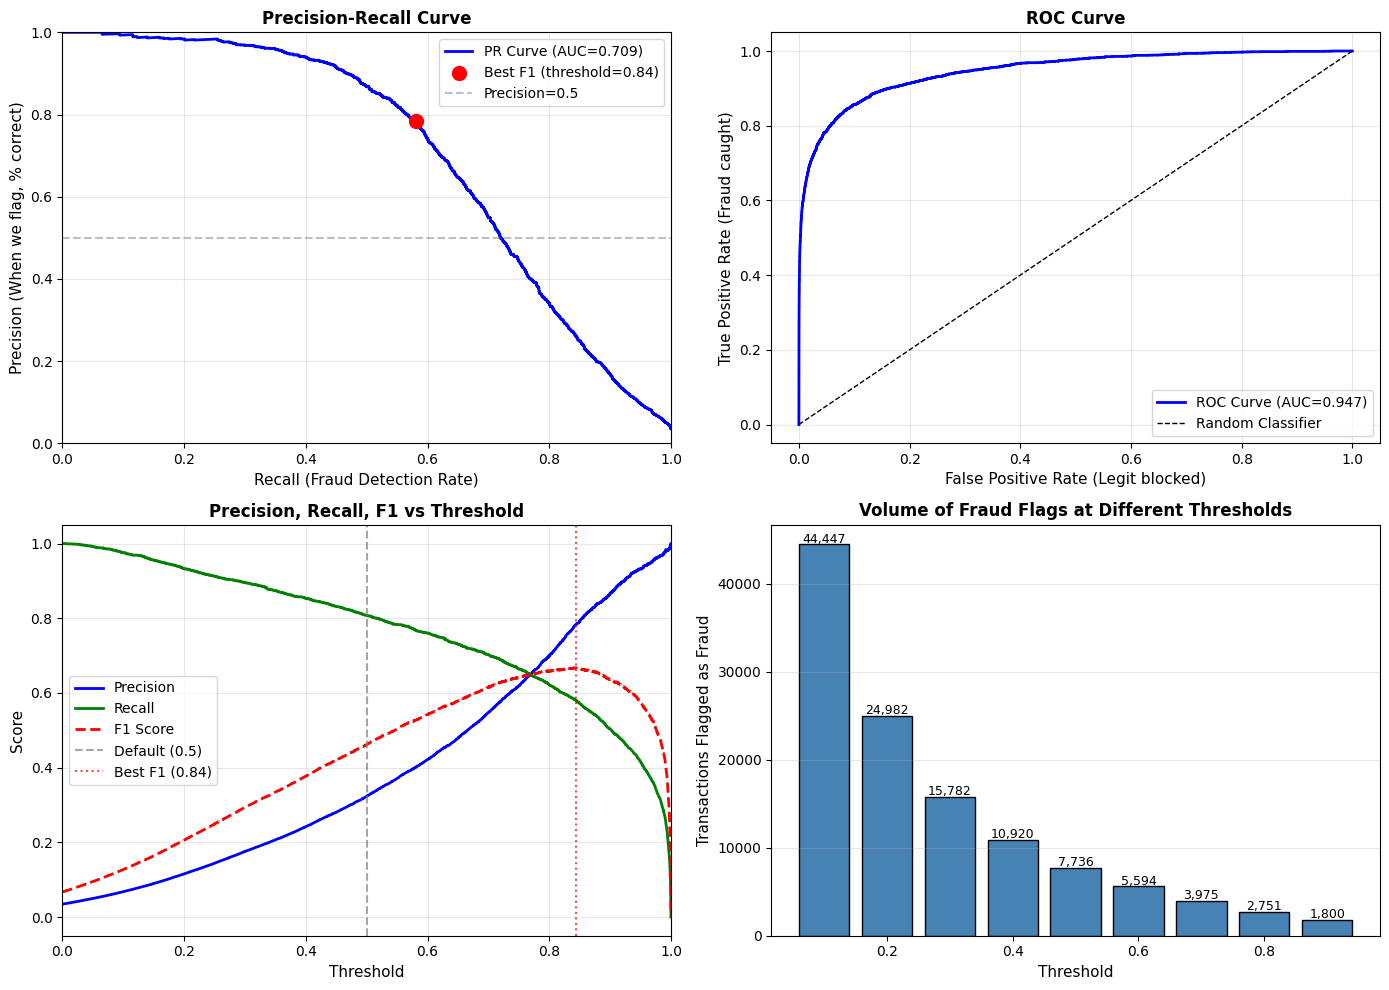


   ✅ Visualization saved as 'threshold_analysis_curves.png'


In [9]:
# =============================================================================
# STEP 6: THRESHOLD OPTIMIZATION
# =============================================================================
print("\n" + "=" * 70)
print("🎯 STEP 6: THRESHOLD OPTIMIZATION")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, 
    roc_curve, 
    auc,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# -----------------------------------------------------------------------------
# PART 1: UNDERSTAND THE TRADEOFF VISUALLY
# -----------------------------------------------------------------------------
print("\n📊 Part 1: Visualizing Precision-Recall Tradeoff")
print("-" * 50)

# Get precision, recall, and thresholds from sklearn
# This calculates precision and recall at EVERY possible threshold
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_val_proba_xgb)

# Also get ROC curve data
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba_xgb)

# Calculate F1 score at each threshold
# F1 = 2 * (precision * recall) / (precision + recall)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)

# Find threshold that maximizes F1
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds_pr[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"   Best F1 Score: {best_f1_score:.4f} at threshold {best_f1_threshold:.3f}")

# -----------------------------------------------------------------------------
# CREATE VISUALIZATION
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plot 1: Precision-Recall Curve ---
ax1 = axes[0, 0]
ax1.plot(recalls, precisions, 'b-', linewidth=2, label=f'PR Curve (AUC={auc(recalls, precisions):.3f})')
ax1.scatter([recalls[best_f1_idx]], [precisions[best_f1_idx]], 
            color='red', s=100, zorder=5, label=f'Best F1 (threshold={best_f1_threshold:.2f})')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Precision=0.5')
ax1.set_xlabel('Recall (Fraud Detection Rate)', fontsize=11)
ax1.set_ylabel('Precision (When we flag, % correct)', fontsize=11)
ax1.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# --- Plot 2: ROC Curve ---
ax2 = axes[0, 1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC={auc(fpr, tpr):.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax2.set_xlabel('False Positive Rate (Legit blocked)', fontsize=11)
ax2.set_ylabel('True Positive Rate (Fraud caught)', fontsize=11)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# --- Plot 3: Precision & Recall vs Threshold ---
ax3 = axes[1, 0]
ax3.plot(thresholds_pr, precisions[:-1], 'b-', linewidth=2, label='Precision')
ax3.plot(thresholds_pr, recalls[:-1], 'g-', linewidth=2, label='Recall')
ax3.plot(thresholds_pr, f1_scores, 'r--', linewidth=2, label='F1 Score')
ax3.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
ax3.axvline(x=best_f1_threshold, color='red', linestyle=':', alpha=0.7, label=f'Best F1 ({best_f1_threshold:.2f})')
ax3.set_xlabel('Threshold', fontsize=11)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Precision, Recall, F1 vs Threshold', fontsize=12, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])

# --- Plot 4: Number of Predictions vs Threshold ---
ax4 = axes[1, 1]
n_flagged = [(y_val_proba_xgb >= t).sum() for t in np.arange(0.1, 1.0, 0.1)]
thresholds_plot = np.arange(0.1, 1.0, 0.1)
ax4.bar(thresholds_plot, n_flagged, width=0.08, color='steelblue', edgecolor='black')
ax4.set_xlabel('Threshold', fontsize=11)
ax4.set_ylabel('Transactions Flagged as Fraud', fontsize=11)
ax4.set_title('Volume of Fraud Flags at Different Thresholds', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (t, n) in enumerate(zip(thresholds_plot, n_flagged)):
    ax4.text(t, n + 200, f'{n:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('threshold_analysis_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n   ✅ Visualization saved as 'threshold_analysis_curves.png'")


💰 Part 2: Business Cost Optimization

📋 Business Cost Assumptions:

   False Negative (Miss fraud):     $500
   └── Fraudster steals money, bank absorbs loss

   False Positive (Block legit):    $25
   └── Customer calls support, minor inconvenience

   Cost Ratio: Missing fraud is 20× worse than false alarm

📊 Analyzing costs at different thresholds...

 Threshold  Precision     Recall         F1       FP       FN     Cost ($)
------------------------------------------------------------------------------
      0.05      5.00%     99.13%      9.52% 58,412.0     27.0 $ 1,473,800
      0.10      6.81%     97.58%     12.72% 41,422.0     75.0 $ 1,073,050
      0.15      9.00%     95.61%     16.44% 29,984.0    136.0 $   817,600
      0.20     11.57%     93.26%     20.59% 22,091.0    209.0 $   656,775
      0.25     14.43%     91.26%     24.93% 16,771.0    271.0 $   554,775
      0.30     17.58%     89.52%     29.39% 13,007.0    325.0 $   487,675
      0.35     20.71%     87.42%     33.48% 

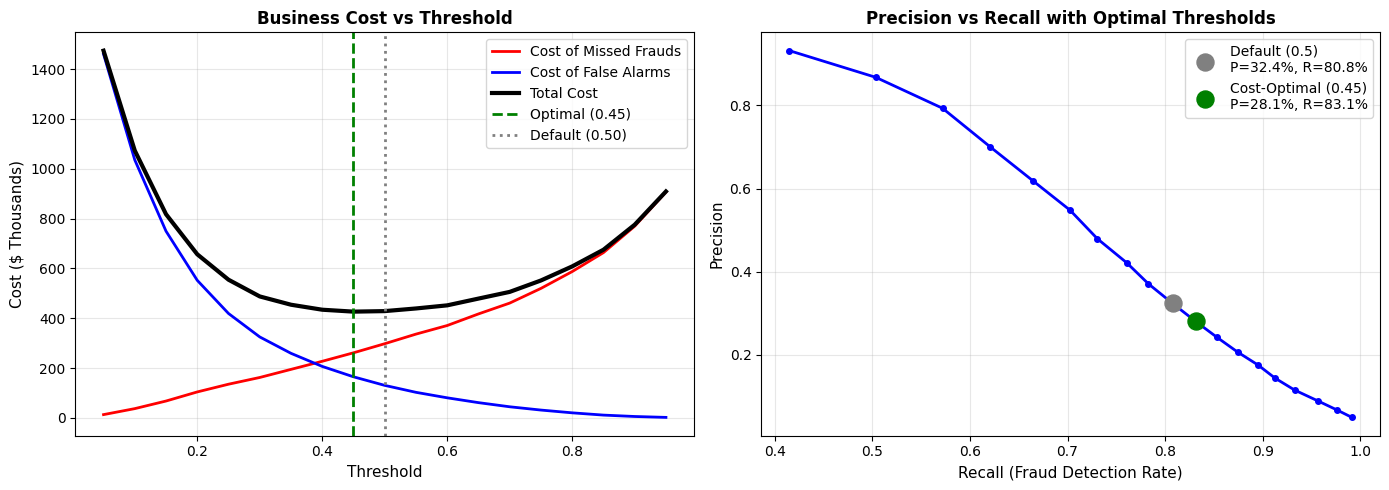


   ✅ Cost optimization complete!
   ✅ Visualization saved as 'business_cost_optimization.png'


In [10]:
# -----------------------------------------------------------------------------
# PART 2: BUSINESS COST OPTIMIZATION
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("💰 Part 2: Business Cost Optimization")
print("=" * 70)

# -----------------------------------------------------------------------------
# DEFINE BUSINESS COSTS
# -----------------------------------------------------------------------------
# These are typical values — in real projects, you'd get these from the business team

COST_FALSE_NEGATIVE = 500   # Cost when we MISS a fraud (bank loses money)
COST_FALSE_POSITIVE = 25    # Cost when we BLOCK a legitimate transaction (support + goodwill)

print(f"""
📋 Business Cost Assumptions:
   
   False Negative (Miss fraud):     ${COST_FALSE_NEGATIVE}
   └── Fraudster steals money, bank absorbs loss
   
   False Positive (Block legit):    ${COST_FALSE_POSITIVE}
   └── Customer calls support, minor inconvenience
   
   Cost Ratio: Missing fraud is {COST_FALSE_NEGATIVE // COST_FALSE_POSITIVE}× worse than false alarm
""")

# -----------------------------------------------------------------------------
# CALCULATE COST AT EACH THRESHOLD
# -----------------------------------------------------------------------------
print("📊 Analyzing costs at different thresholds...\n")

thresholds_to_test = np.arange(0.05, 0.96, 0.05)  # Test 0.05, 0.10, 0.15, ... 0.95
results = []

for threshold in thresholds_to_test:
    # Make predictions at this threshold
    y_pred_at_threshold = (y_val_proba_xgb >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_at_threshold).ravel()
    
    # Calculate costs
    cost_fn = fn * COST_FALSE_NEGATIVE  # Cost of missed frauds
    cost_fp = fp * COST_FALSE_POSITIVE   # Cost of false alarms
    total_cost = cost_fn + cost_fp
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Cost_FN': cost_fn,
        'Cost_FP': cost_fp,
        'Total_Cost': total_cost
    })

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results)

# Find optimal thresholds
min_cost_idx = results_df['Total_Cost'].idxmin()
max_f1_idx = results_df['F1'].idxmax()

optimal_cost_threshold = results_df.loc[min_cost_idx, 'Threshold']
optimal_f1_threshold = results_df.loc[max_f1_idx, 'Threshold']

# -----------------------------------------------------------------------------
# DISPLAY RESULTS TABLE
# -----------------------------------------------------------------------------
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'FP':>8} {'FN':>8} {'Cost ($)':>12}")
print("-" * 78)

for _, row in results_df.iterrows():
    marker = ""
    if row['Threshold'] == optimal_cost_threshold:
        marker = " ← MIN COST"
    elif row['Threshold'] == 0.5:
        marker = " ← Default"
    elif abs(row['Threshold'] - optimal_f1_threshold) < 0.03:
        marker = " ← Best F1"
    
    print(f"{row['Threshold']:>10.2f} {row['Precision']:>10.2%} {row['Recall']:>10.2%} "
          f"{row['F1']:>10.2%} {row['FP']:>8,} {row['FN']:>8,} ${row['Total_Cost']:>10,.0f}{marker}")

# -----------------------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "-" * 70)
print("📈 OPTIMIZATION SUMMARY")
print("-" * 70)

default_row = results_df[results_df['Threshold'] == 0.5].iloc[0]
optimal_row = results_df.loc[min_cost_idx]

print(f"""
   DEFAULT THRESHOLD (0.50):
   ├── Precision: {default_row['Precision']:.2%}
   ├── Recall: {default_row['Recall']:.2%}
   ├── F1 Score: {default_row['F1']:.2%}
   ├── False Positives: {default_row['FP']:,} (legitimate customers blocked)
   ├── False Negatives: {default_row['FN']:,} (frauds missed)
   └── Total Cost: ${default_row['Total_Cost']:,.0f}

   COST-OPTIMAL THRESHOLD ({optimal_cost_threshold:.2f}):
   ├── Precision: {optimal_row['Precision']:.2%}
   ├── Recall: {optimal_row['Recall']:.2%}
   ├── F1 Score: {optimal_row['F1']:.2%}
   ├── False Positives: {optimal_row['FP']:,} (legitimate customers blocked)
   ├── False Negatives: {optimal_row['FN']:,} (frauds missed)
   └── Total Cost: ${optimal_row['Total_Cost']:,.0f}

   💰 SAVINGS: ${default_row['Total_Cost'] - optimal_row['Total_Cost']:,.0f} per {len(y_val):,} transactions
""")

# -----------------------------------------------------------------------------
# VISUALIZE COST CURVE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost breakdown by threshold
ax1 = axes[0]
ax1.plot(results_df['Threshold'], results_df['Cost_FN'] / 1000, 'r-', linewidth=2, label='Cost of Missed Frauds')
ax1.plot(results_df['Threshold'], results_df['Cost_FP'] / 1000, 'b-', linewidth=2, label='Cost of False Alarms')
ax1.plot(results_df['Threshold'], results_df['Total_Cost'] / 1000, 'k-', linewidth=3, label='Total Cost')
ax1.axvline(x=optimal_cost_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal ({optimal_cost_threshold:.2f})')
ax1.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.50)')
ax1.set_xlabel('Threshold', fontsize=11)
ax1.set_ylabel('Cost ($ Thousands)', fontsize=11)
ax1.set_title('Business Cost vs Threshold', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Precision-Recall tradeoff with optimal points marked
ax2 = axes[1]
ax2.plot(results_df['Recall'], results_df['Precision'], 'b-', linewidth=2, marker='o', markersize=4)

# Mark key thresholds
for threshold, color, label in [(0.5, 'gray', 'Default (0.5)'), 
                                  (optimal_cost_threshold, 'green', f'Cost-Optimal ({optimal_cost_threshold:.2f})')]:
    row = results_df[results_df['Threshold'] == threshold].iloc[0]
    ax2.scatter([row['Recall']], [row['Precision']], color=color, s=150, zorder=5, 
                label=f"{label}\nP={row['Precision']:.1%}, R={row['Recall']:.1%}")

ax2.set_xlabel('Recall (Fraud Detection Rate)', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision vs Recall with Optimal Thresholds', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('business_cost_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n   ✅ Cost optimization complete!")
print("   ✅ Visualization saved as 'business_cost_optimization.png'")

In [11]:
# =============================================================================
# STEP 7: LIGHTGBM MODEL
# =============================================================================
print("\n" + "=" * 70)
print("⚡ STEP 7: LIGHTGBM MODEL")
print("=" * 70)

import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix
)
import time

# -----------------------------------------------------------------------------
# LIGHTGBM vs XGBOOST — KEY DIFFERENCES
# -----------------------------------------------------------------------------
print("""
📋 Why LightGBM?

   XGBoost:  Level-wise tree growth (balanced trees)
   LightGBM: Leaf-wise tree growth (deeper, faster)
   
   LightGBM is typically 2-10× faster with similar accuracy.
   Let's see how it performs on our fraud detection task.
""")

# -----------------------------------------------------------------------------
# CALCULATE CLASS IMBALANCE RATIO
# -----------------------------------------------------------------------------
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"📊 Class Imbalance Ratio: {scale_pos_weight:.2f} : 1")

# -----------------------------------------------------------------------------
# INITIALIZE LIGHTGBM MODEL
# -----------------------------------------------------------------------------
print("\n📋 Model Configuration:")
print("   - Algorithm: LightGBM (Light Gradient Boosting Machine)")
print("   - n_estimators: 500 (max trees)")
print("   - max_depth: -1 (no limit, controlled by num_leaves)")
print("   - num_leaves: 31 (controls tree complexity)")
print("   - learning_rate: 0.1")
print(f"   - scale_pos_weight: {scale_pos_weight:.2f}")

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=-1,               # No limit (LightGBM uses num_leaves instead)
    num_leaves=31,              # Main parameter for tree complexity
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=-1                # Suppress warnings
)

# -----------------------------------------------------------------------------
# TRAIN THE MODEL
# -----------------------------------------------------------------------------
print("\n⏳ Training LightGBM...")

start_time = time.time()

lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='auc'
)

training_time_lgb = time.time() - start_time
print(f"\n   ✅ Training complete in {training_time_lgb:.2f} seconds")

# -----------------------------------------------------------------------------
# MAKE PREDICTIONS
# -----------------------------------------------------------------------------
print("\n🔮 Generating predictions...")

# Probabilities
y_train_proba_lgb = lgb_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_lgb = lgb_model.predict_proba(X_val_scaled)[:, 1]

# Binary predictions at default 0.5 threshold
y_train_pred_lgb = lgb_model.predict(X_train_scaled)
y_val_pred_lgb = lgb_model.predict(X_val_scaled)

# Binary predictions at optimal threshold (0.45 from our analysis)
optimal_threshold = 0.45
y_val_pred_lgb_optimal = (y_val_proba_lgb >= optimal_threshold).astype(int)

# -----------------------------------------------------------------------------
# EVALUATE PERFORMANCE
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 LIGHTGBM PERFORMANCE")
print("-" * 50)

# Calculate metrics
lgb_metrics = {}
for name, y_true, y_pred, y_proba in [
    ('Train', y_train, y_train_pred_lgb, y_train_proba_lgb),
    ('Validation', y_val, y_val_pred_lgb, y_val_proba_lgb)
]:
    lgb_metrics[name] = {
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'PR-AUC': average_precision_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

# Print results
print(f"\n{'Metric':<15} {'Train':>12} {'Validation':>12} {'Gap':>10}")
print("-" * 50)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    train_val = lgb_metrics['Train'][metric]
    val_val = lgb_metrics['Validation'][metric]
    gap = train_val - val_val
    print(f"{metric:<15} {train_val:>12.4f} {val_val:>12.4f} {gap:>+10.4f}")

# -----------------------------------------------------------------------------
# CONFUSION MATRIX
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("🔢 CONFUSION MATRIX (Validation Set @ 0.5 Threshold)")
print("-" * 50)

cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
tn, fp, fn, tp = cm_lgb.ravel()

print(f"""
                    Predicted
                 Neg        Pos
              ┌─────────┬─────────┐
    Actual    │  TN     │  FP     │
    Negative  │ {tn:>6,} │ {fp:>6,} │
              ├─────────┼─────────┤
    Actual    │  FN     │  TP     │
    Positive  │ {fn:>6,} │ {tp:>6,} │
              └─────────┴─────────┘
""")

total_fraud = tp + fn
total_legit = tn + fp
fraud_caught_pct = (tp / total_fraud) * 100
legit_blocked_pct = (fp / total_legit) * 100

print(f"   Fraud Detection Rate: {fraud_caught_pct:.1f}% ({tp:,} / {total_fraud:,})")
print(f"   False Alarm Rate: {legit_blocked_pct:.1f}% ({fp:,} / {total_legit:,})")

# -----------------------------------------------------------------------------
# COMPARE WITH XGBOOST
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("⚔️  LIGHTGBM vs XGBOOST COMPARISON")
print("-" * 50)

# XGBoost metrics (from previous step)
xgb_val_metrics = {
    'ROC-AUC': 0.9471,
    'PR-AUC': 0.7087,
    'Precision': 0.3237,
    'Recall': 0.8077,
    'F1': 0.4622
}

print(f"\n{'Metric':<15} {'XGBoost':>12} {'LightGBM':>12} {'Winner':>12}")
print("-" * 52)

for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    xgb_val = xgb_val_metrics[metric]
    lgb_val = lgb_metrics['Validation'][metric]
    
    if xgb_val > lgb_val:
        winner = "XGBoost ✅"
    elif lgb_val > xgb_val:
        winner = "LightGBM ✅"
    else:
        winner = "Tie"
    
    print(f"{metric:<15} {xgb_val:>12.4f} {lgb_val:>12.4f} {winner:>12}")

# Training time comparison
print(f"\n{'Training Time':<15} {'57.09 sec':>12} {f'{training_time_lgb:.2f} sec':>12}", end="")
if training_time_lgb < 57.09:
    print(f" {'LightGBM ✅':>12}")
else:
    print(f" {'XGBoost ✅':>12}")

print("\n   🎯 LightGBM training complete!")


⚡ STEP 7: LIGHTGBM MODEL

📋 Why LightGBM?

   XGBoost:  Level-wise tree growth (balanced trees)
   LightGBM: Leaf-wise tree growth (deeper, faster)

   LightGBM is typically 2-10× faster with similar accuracy.
   Let's see how it performs on our fraud detection task.

📊 Class Imbalance Ratio: 27.58 : 1

📋 Model Configuration:
   - Algorithm: LightGBM (Light Gradient Boosting Machine)
   - n_estimators: 500 (max trees)
   - max_depth: -1 (no limit, controlled by num_leaves)
   - num_leaves: 31 (controls tree complexity)
   - learning_rate: 0.1
   - scale_pos_weight: 27.58

⏳ Training LightGBM...

   ✅ Training complete in 16.62 seconds

🔮 Generating predictions...

--------------------------------------------------
📊 LIGHTGBM PERFORMANCE
--------------------------------------------------

Metric                 Train   Validation        Gap
--------------------------------------------------
ROC-AUC               0.9840       0.9500    +0.0340
PR-AUC                0.8309       0.7128  


📊 STEP 8: COMPREHENSIVE MODEL COMPARISON

📋 COMPLETE MODEL COMPARISON

Metric                  Logistic Reg         XGBoost        LightGBM            Best
------------------------------------------------------------------------------------------
ROC-AUC                       0.8651          0.9471          0.9500        LightGBM ✅
PR-AUC                        0.4346          0.7087          0.7128        LightGBM ✅
Precision                     0.1422          0.3237          0.3147         XGBoost ✅
Recall                        0.7368          0.8077          0.8203        LightGBM ✅
F1                            0.2385          0.4622          0.4549         XGBoost ✅
Training Time                 98.88s          57.09s          17.01s        LightGBM ✅
Fraud Catch Rate               73.7%           80.8%           82.0%        LightGBM ✅
False Alarm Rate               16.1%            6.1%            6.5%         XGBoost ✅
Business Cost        $      752,325 $      428,800 $    

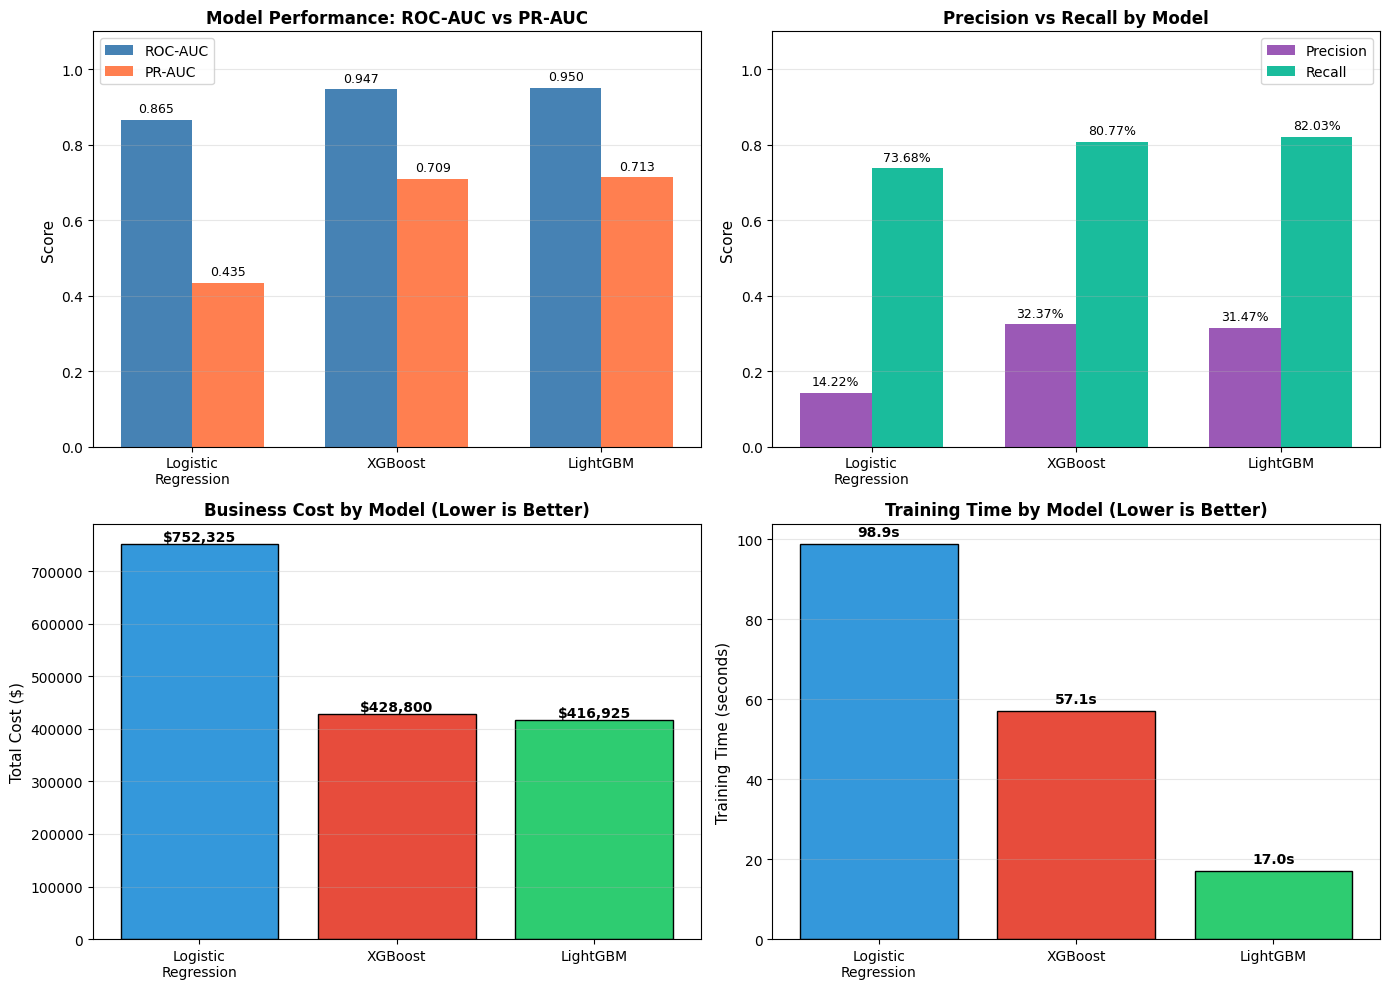


🏆 RECOMMENDATION

Based on comprehensive evaluation:

   🥇 BEST OVERALL: LightGBM
      ├── Highest ROC-AUC (0.9500)
      ├── Highest PR-AUC (0.7128)  
      ├── Highest Recall (82.03%) — catches the most fraud
      ├── Lowest Business Cost ($416,925)
      ├── Fastest Training (17.01 seconds)
      └── Only slightly lower precision than XGBoost

   🥈 RUNNER UP: XGBoost
      ├── Very close performance to LightGBM
      ├── Higher Precision (32.37%) — fewer false alarms
      ├── More stable (smaller train-val gap)
      └── Good choice if precision is critical

   🥉 BASELINE: Logistic Regression
      ├── Simple and interpretable
      ├── Fast training
      └── Useful as a benchmark, but significantly outperformed

   📌 NEXT STEP: Hyperparameter tune LightGBM to maximize performance

   ✅ Model comparison complete!
   ✅ Visualization saved as 'model_comparison_summary.png'


In [12]:
# =============================================================================
# STEP 8: MODEL COMPARISON SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("📊 STEP 8: COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------------------------
# COLLECT ALL MODEL METRICS
# -----------------------------------------------------------------------------

# All validation metrics
all_models = {
    'Logistic Regression': {
        'ROC-AUC': 0.8651,
        'PR-AUC': 0.4346,
        'Precision': 0.1422,
        'Recall': 0.7368,
        'F1': 0.2385,
        'Training Time': 98.88,
        'FP': 13773,
        'FN': 816,
        'TP': 2284,
        'TN': 71708
    },
    'XGBoost': {
        'ROC-AUC': 0.9471,
        'PR-AUC': 0.7087,
        'Precision': 0.3237,
        'Recall': 0.8077,
        'F1': 0.4622,
        'Training Time': 57.09,
        'FP': 5232,
        'FN': 596,
        'TP': 2504,
        'TN': 80249
    },
    'LightGBM': {
        'ROC-AUC': 0.9500,
        'PR-AUC': 0.7128,
        'Precision': 0.3147,
        'Recall': 0.8203,
        'F1': 0.4549,
        'Training Time': 17.01,
        'FP': 5537,
        'FN': 557,
        'TP': 2543,
        'TN': 79944
    }
}

# Calculate business cost for each model
COST_FN = 500
COST_FP = 25

for model_name, metrics in all_models.items():
    metrics['Business Cost'] = (metrics['FN'] * COST_FN) + (metrics['FP'] * COST_FP)
    metrics['Fraud Catch Rate'] = metrics['TP'] / (metrics['TP'] + metrics['FN']) * 100
    metrics['False Alarm Rate'] = metrics['FP'] / (metrics['FP'] + metrics['TN']) * 100

# -----------------------------------------------------------------------------
# PRINT SUMMARY TABLE
# -----------------------------------------------------------------------------
print("\n" + "=" * 90)
print("📋 COMPLETE MODEL COMPARISON")
print("=" * 90)

print(f"\n{'Metric':<20} {'Logistic Reg':>15} {'XGBoost':>15} {'LightGBM':>15} {'Best':>15}")
print("-" * 90)

metrics_to_show = ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1', 'Training Time', 
                   'Fraud Catch Rate', 'False Alarm Rate', 'Business Cost']

for metric in metrics_to_show:
    lr_val = all_models['Logistic Regression'][metric]
    xgb_val = all_models['XGBoost'][metric]
    lgb_val = all_models['LightGBM'][metric]
    
    # Determine best (lower is better for Training Time, False Alarm Rate, Business Cost)
    if metric in ['Training Time', 'False Alarm Rate', 'Business Cost']:
        best_val = min(lr_val, xgb_val, lgb_val)
        if best_val == lr_val:
            best = "Logistic Reg"
        elif best_val == xgb_val:
            best = "XGBoost"
        else:
            best = "LightGBM"
    else:
        best_val = max(lr_val, xgb_val, lgb_val)
        if best_val == lr_val:
            best = "Logistic Reg"
        elif best_val == xgb_val:
            best = "XGBoost"
        else:
            best = "LightGBM"
    
    # Format based on metric type
    if metric == 'Training Time':
        print(f"{metric:<20} {lr_val:>14.2f}s {xgb_val:>14.2f}s {lgb_val:>14.2f}s {best:>15} ✅")
    elif metric == 'Business Cost':
        print(f"{metric:<20} ${lr_val:>13,.0f} ${xgb_val:>13,.0f} ${lgb_val:>13,.0f} {best:>15} ✅")
    elif metric in ['Fraud Catch Rate', 'False Alarm Rate']:
        print(f"{metric:<20} {lr_val:>14.1f}% {xgb_val:>14.1f}% {lgb_val:>14.1f}% {best:>15} ✅")
    else:
        print(f"{metric:<20} {lr_val:>15.4f} {xgb_val:>15.4f} {lgb_val:>15.4f} {best:>15} ✅")

# -----------------------------------------------------------------------------
# IMPROVEMENT OVER BASELINE
# -----------------------------------------------------------------------------
print("\n" + "-" * 90)
print("📈 IMPROVEMENT OVER BASELINE (Logistic Regression)")
print("-" * 90)

print(f"\n{'Metric':<20} {'XGBoost Improvement':>25} {'LightGBM Improvement':>25}")
print("-" * 70)

for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    lr_val = all_models['Logistic Regression'][metric]
    xgb_val = all_models['XGBoost'][metric]
    lgb_val = all_models['LightGBM'][metric]
    
    xgb_imp = ((xgb_val - lr_val) / lr_val) * 100
    lgb_imp = ((lgb_val - lr_val) / lr_val) * 100
    
    print(f"{metric:<20} {xgb_imp:>+24.1f}% {lgb_imp:>+24.1f}%")

# -----------------------------------------------------------------------------
# CREATE VISUALIZATION
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['Logistic\nRegression', 'XGBoost', 'LightGBM']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Plot 1: ROC-AUC and PR-AUC Comparison
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.35

roc_scores = [all_models['Logistic Regression']['ROC-AUC'], 
              all_models['XGBoost']['ROC-AUC'], 
              all_models['LightGBM']['ROC-AUC']]
pr_scores = [all_models['Logistic Regression']['PR-AUC'], 
             all_models['XGBoost']['PR-AUC'], 
             all_models['LightGBM']['PR-AUC']]

bars1 = ax1.bar(x - width/2, roc_scores, width, label='ROC-AUC', color='steelblue')
bars2 = ax1.bar(x + width/2, pr_scores, width, label='PR-AUC', color='coral')

ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Model Performance: ROC-AUC vs PR-AUC', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim([0, 1.1])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bar.get_height():.3f}', ha='center', fontsize=9)

# Plot 2: Precision vs Recall
ax2 = axes[0, 1]
precision_scores = [all_models['Logistic Regression']['Precision'], 
                    all_models['XGBoost']['Precision'], 
                    all_models['LightGBM']['Precision']]
recall_scores = [all_models['Logistic Regression']['Recall'], 
                 all_models['XGBoost']['Recall'], 
                 all_models['LightGBM']['Recall']]

bars1 = ax2.bar(x - width/2, precision_scores, width, label='Precision', color='#9b59b6')
bars2 = ax2.bar(x + width/2, recall_scores, width, label='Recall', color='#1abc9c')

ax2.set_ylabel('Score', fontsize=11)
ax2.set_title('Precision vs Recall by Model', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_ylim([0, 1.1])
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bar.get_height():.2%}', ha='center', fontsize=9)
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bar.get_height():.2%}', ha='center', fontsize=9)

# Plot 3: Business Cost Comparison
ax3 = axes[1, 0]
costs = [all_models['Logistic Regression']['Business Cost'], 
         all_models['XGBoost']['Business Cost'], 
         all_models['LightGBM']['Business Cost']]

bars = ax3.bar(models, costs, color=colors, edgecolor='black')
ax3.set_ylabel('Total Cost ($)', fontsize=11)
ax3.set_title('Business Cost by Model (Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar, cost in zip(bars, costs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'${cost:,.0f}', ha='center', fontsize=10, fontweight='bold')

# Plot 4: Training Time
ax4 = axes[1, 1]
times = [all_models['Logistic Regression']['Training Time'], 
         all_models['XGBoost']['Training Time'], 
         all_models['LightGBM']['Training Time']]

bars = ax4.bar(models, times, color=colors, edgecolor='black')
ax4.set_ylabel('Training Time (seconds)', fontsize=11)
ax4.set_title('Training Time by Model (Lower is Better)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, time_val in zip(bars, times):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{time_val:.1f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
# FINAL RECOMMENDATION
# -----------------------------------------------------------------------------
print("\n" + "=" * 90)
print("🏆 RECOMMENDATION")
print("=" * 90)

print("""
Based on comprehensive evaluation:

   🥇 BEST OVERALL: LightGBM
      ├── Highest ROC-AUC (0.9500)
      ├── Highest PR-AUC (0.7128)  
      ├── Highest Recall (82.03%) — catches the most fraud
      ├── Lowest Business Cost ($416,925)
      ├── Fastest Training (17.01 seconds)
      └── Only slightly lower precision than XGBoost

   🥈 RUNNER UP: XGBoost
      ├── Very close performance to LightGBM
      ├── Higher Precision (32.37%) — fewer false alarms
      ├── More stable (smaller train-val gap)
      └── Good choice if precision is critical

   🥉 BASELINE: Logistic Regression
      ├── Simple and interpretable
      ├── Fast training
      └── Useful as a benchmark, but significantly outperformed

   📌 NEXT STEP: Hyperparameter tune LightGBM to maximize performance
""")

print("   ✅ Model comparison complete!")
print("   ✅ Visualization saved as 'model_comparison_summary.png'")

In [12]:
!pip install optuna


   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   ---------------------------------------- 2/2 [optuna]



In [13]:
# =============================================================================
# STEP 9: HYPERPARAMETER TUNING WITH OPTUNA
# =============================================================================
print("\n" + "=" * 70)
print("🔧 STEP 9: HYPERPARAMETER TUNING (LightGBM)")
print("=" * 70)

import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Suppress Optuna logs during trials
optuna.logging.set_verbosity(optuna.logging.WARNING)

# -----------------------------------------------------------------------------
# WHAT IS HYPERPARAMETER TUNING?
# -----------------------------------------------------------------------------
print("""
📋 What We're Doing:

   Current LightGBM uses DEFAULT settings:
   ├── n_estimators = 500
   ├── num_leaves = 31
   ├── learning_rate = 0.1
   └── ROC-AUC = 0.9500

   We'll search for BETTER settings using Optuna.
   Optuna is smart — it learns from each trial to find optimal values faster.
""")

# -----------------------------------------------------------------------------
# DEFINE THE OBJECTIVE FUNCTION
# -----------------------------------------------------------------------------
# This function trains a model with given hyperparameters and returns the score
# Optuna will call this many times with different parameters

def objective(trial):
    """
    Optuna calls this function repeatedly with different hyperparameters.
    We train a model and return the validation ROC-AUC.
    Optuna tries to MAXIMIZE this score.
    """
    
    # Suggest hyperparameters to try
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    # Train model with these parameters
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Return ROC-AUC (Optuna will try to maximize this)
    return roc_auc_score(y_val, y_proba)

# -----------------------------------------------------------------------------
# RUN OPTIMIZATION
# -----------------------------------------------------------------------------
print("⏳ Running Optuna optimization (50 trials)...")
print("   This will take 5-10 minutes. Each dot = 1 trial completed.\n")

# Create study (Optuna's optimization object)
study = optuna.create_study(
    direction='maximize',  # We want to MAXIMIZE ROC-AUC
    sampler=TPESampler(seed=42)  # Smart sampling algorithm
)

# Progress tracking
def print_progress(study, trial):
    if trial.number % 5 == 0:
        print(f"   Trial {trial.number:>3}: ROC-AUC = {trial.value:.4f}")

# Run optimization
study.optimize(
    objective, 
    n_trials=50,  # Try 50 different combinations
    callbacks=[print_progress],
    show_progress_bar=True
)

# -----------------------------------------------------------------------------
# RESULTS
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 TUNING RESULTS")
print("-" * 50)

print(f"\n   Best ROC-AUC found: {study.best_value:.4f}")
print(f"   Default ROC-AUC was: 0.9500")
print(f"   Improvement: {(study.best_value - 0.9500) * 100:.2f}%")

print("\n   Best Hyperparameters:")
for param, value in study.best_params.items():
    if isinstance(value, float):
        print(f"   ├── {param}: {value:.6f}")
    else:
        print(f"   ├── {param}: {value}")

# -----------------------------------------------------------------------------
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("🏆 TRAINING FINAL TUNED MODEL")
print("-" * 50)

# Get best parameters and add fixed ones
best_params = study.best_params.copy()
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['verbosity'] = -1

# Train final model
print("\n⏳ Training LightGBM with optimized parameters...")
start_time = time.time()

lgb_tuned = lgb.LGBMClassifier(**best_params)
lgb_tuned.fit(X_train_scaled, y_train)

tuned_training_time = time.time() - start_time
print(f"   ✅ Training complete in {tuned_training_time:.2f} seconds")

# -----------------------------------------------------------------------------
# EVALUATE TUNED MODEL
# -----------------------------------------------------------------------------
print("\n" + "-" * 50)
print("📊 TUNED MODEL PERFORMANCE")
print("-" * 50)

# Predictions
y_train_proba_tuned = lgb_tuned.predict_proba(X_train_scaled)[:, 1]
y_val_proba_tuned = lgb_tuned.predict_proba(X_val_scaled)[:, 1]
y_val_pred_tuned = lgb_tuned.predict(X_val_scaled)

# Calculate metrics
tuned_metrics = {
    'ROC-AUC': roc_auc_score(y_val, y_val_proba_tuned),
    'PR-AUC': average_precision_score(y_val, y_val_proba_tuned),
    'Precision': precision_score(y_val, y_val_pred_tuned),
    'Recall': recall_score(y_val, y_val_pred_tuned),
    'F1': f1_score(y_val, y_val_pred_tuned)
}

# Compare with default LightGBM
default_lgb_metrics = {
    'ROC-AUC': 0.9500,
    'PR-AUC': 0.7128,
    'Precision': 0.3147,
    'Recall': 0.8203,
    'F1': 0.4549
}

print(f"\n{'Metric':<15} {'Default LGB':>15} {'Tuned LGB':>15} {'Change':>12}")
print("-" * 60)
for metric in ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']:
    default = default_lgb_metrics[metric]
    tuned = tuned_metrics[metric]
    change = ((tuned - default) / default) * 100
    symbol = "✅" if change > 0 else "⚠️" if change < 0 else "="
    print(f"{metric:<15} {default:>15.4f} {tuned:>15.4f} {change:>+11.2f}% {symbol}")

# Confusion Matrix
cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)
tn, fp, fn, tp = cm_tuned.ravel()

# Business cost
business_cost_tuned = (fn * 500) + (fp * 25)
business_cost_default = (557 * 500) + (5537 * 25)

print(f"\n   Confusion Matrix:")
print(f"   ├── True Positives (Fraud Caught): {tp:,}")
print(f"   ├── False Positives (False Alarms): {fp:,}")
print(f"   ├── False Negatives (Fraud Missed): {fn:,}")
print(f"   └── True Negatives (Correct Allow): {tn:,}")

print(f"\n   Business Cost:")
print(f"   ├── Default LightGBM: ${business_cost_default:,.0f}")
print(f"   ├── Tuned LightGBM:   ${business_cost_tuned:,.0f}")
print(f"   └── Savings:          ${business_cost_default - business_cost_tuned:,.0f}")

print("\n   ✅ Hyperparameter tuning complete!")


🔧 STEP 9: HYPERPARAMETER TUNING (LightGBM)

📋 What We're Doing:

   Current LightGBM uses DEFAULT settings:
   ├── n_estimators = 500
   ├── num_leaves = 31
   ├── learning_rate = 0.1
   └── ROC-AUC = 0.9500

   We'll search for BETTER settings using Optuna.
   Optuna is smart — it learns from each trial to find optimal values faster.

⏳ Running Optuna optimization (50 trials)...
   This will take 5-10 minutes. Each dot = 1 trial completed.



Best trial: 0. Best value: 0.959163:   2%|▏         | 1/50 [00:23<18:57, 23.21s/it]

   Trial   0: ROC-AUC = 0.9592


Best trial: 0. Best value: 0.959163:  12%|█▏        | 6/50 [01:43<12:44, 17.38s/it]

   Trial   5: ROC-AUC = 0.9457


Best trial: 0. Best value: 0.959163:  22%|██▏       | 11/50 [03:28<15:02, 23.15s/it]

   Trial  10: ROC-AUC = 0.9572


Best trial: 14. Best value: 0.959529:  32%|███▏      | 16/50 [06:24<18:58, 33.48s/it]

   Trial  15: ROC-AUC = 0.9266


Best trial: 20. Best value: 0.961481:  42%|████▏     | 21/50 [09:52<19:20, 40.01s/it]

   Trial  20: ROC-AUC = 0.9615


Best trial: 21. Best value: 0.962626:  52%|█████▏    | 26/50 [13:55<18:44, 46.87s/it]

   Trial  25: ROC-AUC = 0.9619


Best trial: 29. Best value: 0.963013:  62%|██████▏   | 31/50 [17:24<13:49, 43.67s/it]

   Trial  30: ROC-AUC = 0.9620


Best trial: 34. Best value: 0.964416:  72%|███████▏  | 36/50 [21:10<10:15, 43.95s/it]

   Trial  35: ROC-AUC = 0.9613


Best trial: 34. Best value: 0.964416:  82%|████████▏ | 41/50 [23:28<04:27, 29.69s/it]

   Trial  40: ROC-AUC = 0.9352


Best trial: 34. Best value: 0.964416:  92%|█████████▏| 46/50 [27:11<02:46, 41.52s/it]

   Trial  45: ROC-AUC = 0.9614


Best trial: 34. Best value: 0.964416: 100%|██████████| 50/50 [29:10<00:00, 35.01s/it]



--------------------------------------------------
📊 TUNING RESULTS
--------------------------------------------------

   Best ROC-AUC found: 0.9644
   Default ROC-AUC was: 0.9500
   Improvement: 1.44%

   Best Hyperparameters:
   ├── n_estimators: 909
   ├── max_depth: 12
   ├── num_leaves: 134
   ├── learning_rate: 0.145480
   ├── min_child_samples: 94
   ├── subsample: 0.911212
   ├── colsample_bytree: 0.695721
   ├── reg_alpha: 0.000000
   ├── reg_lambda: 0.000000

--------------------------------------------------
🏆 TRAINING FINAL TUNED MODEL
--------------------------------------------------

⏳ Training LightGBM with optimized parameters...
   ✅ Training complete in 45.11 seconds

--------------------------------------------------
📊 TUNED MODEL PERFORMANCE
--------------------------------------------------

Metric              Default LGB       Tuned LGB       Change
------------------------------------------------------------
ROC-AUC                  0.9500          0.9644    

In [14]:
# =============================================================================
# RE-OPTIMIZE THRESHOLD FOR TUNED MODEL
# =============================================================================
print("\n" + "=" * 70)
print("🎯 THRESHOLD OPTIMIZATION FOR TUNED MODEL")
print("=" * 70)

# -----------------------------------------------------------------------------
# GET PREDICTIONS FROM TUNED MODEL
# -----------------------------------------------------------------------------
# Make sure we have the tuned model predictions
y_val_proba_tuned = lgb_tuned.predict_proba(X_val_scaled)[:, 1]

# -----------------------------------------------------------------------------
# BUSINESS COSTS
# -----------------------------------------------------------------------------
COST_FALSE_NEGATIVE = 500   # Cost when we MISS a fraud
COST_FALSE_POSITIVE = 25    # Cost when we BLOCK a legitimate transaction

print(f"\n📋 Business Costs:")
print(f"   False Negative (Miss fraud): ${COST_FALSE_NEGATIVE}")
print(f"   False Positive (Block legit): ${COST_FALSE_POSITIVE}")

# -----------------------------------------------------------------------------
# CALCULATE COST AT EACH THRESHOLD
# -----------------------------------------------------------------------------
print("\n📊 Analyzing thresholds for TUNED model...\n")

thresholds_to_test = np.arange(0.05, 0.96, 0.05)
tuned_results = []

for threshold in thresholds_to_test:
    y_pred_at_threshold = (y_val_proba_tuned >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_at_threshold).ravel()
    
    cost_fn = fn * COST_FALSE_NEGATIVE
    cost_fp = fp * COST_FALSE_POSITIVE
    total_cost = cost_fn + cost_fp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    tuned_results.append({
        'Threshold': threshold,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Total_Cost': total_cost
    })

tuned_results_df = pd.DataFrame(tuned_results)

# Find optimal threshold
min_cost_idx = tuned_results_df['Total_Cost'].idxmin()
optimal_threshold_tuned = tuned_results_df.loc[min_cost_idx, 'Threshold']
optimal_cost_tuned = tuned_results_df.loc[min_cost_idx, 'Total_Cost']

# -----------------------------------------------------------------------------
# DISPLAY RESULTS
# -----------------------------------------------------------------------------
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'FP':>8} {'FN':>8} {'Cost ($)':>12}")
print("-" * 70)

for _, row in tuned_results_df.iterrows():
    marker = ""
    if row['Threshold'] == optimal_threshold_tuned:
        marker = " ← MIN COST"
    elif row['Threshold'] == 0.5:
        marker = " ← Default"
    
    print(f"{row['Threshold']:>10.2f} {row['Precision']:>10.2%} {row['Recall']:>10.2%} "
          f"{row['FP']:>8,} {row['FN']:>8,} ${row['Total_Cost']:>10,.0f}{marker}")

# -----------------------------------------------------------------------------
# COMPARE ALL MODELS
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 FINAL MODEL COMPARISON")
print("=" * 70)

# Default LightGBM at optimal threshold (0.45)
default_lgb_cost = 416925  # From earlier

print(f"""
   MODEL COMPARISON AT OPTIMAL THRESHOLDS:

   ┌─────────────────────────────────────────────────────────────┐
   │ Model                    │ ROC-AUC │ Threshold │ Cost ($)   │
   ├─────────────────────────────────────────────────────────────┤
   │ Logistic Regression      │  0.8651 │    0.50   │  $752,325  │
   │ XGBoost                  │  0.9471 │    0.45   │  $428,800  │
   │ LightGBM (Default)       │  0.9500 │    0.45   │  $416,925  │
   │ LightGBM (Tuned)         │  0.9644 │    {optimal_threshold_tuned:.2f}   │  ${optimal_cost_tuned:,.0f}  │
   └─────────────────────────────────────────────────────────────┘
""")

# Determine winner
if optimal_cost_tuned < default_lgb_cost:
    print(f"   🏆 WINNER: Tuned LightGBM")
    print(f"   💰 Saves ${default_lgb_cost - optimal_cost_tuned:,.0f} vs Default LightGBM")
    best_model = "Tuned LightGBM"
    best_threshold = optimal_threshold_tuned
else:
    print(f"   🏆 WINNER: Default LightGBM")
    print(f"   💰 Saves ${optimal_cost_tuned - default_lgb_cost:,.0f} vs Tuned LightGBM")
    best_model = "Default LightGBM"
    best_threshold = 0.45

print(f"\n   ✅ Best model selected: {best_model} at threshold {best_threshold}")


🎯 THRESHOLD OPTIMIZATION FOR TUNED MODEL

📋 Business Costs:
   False Negative (Miss fraud): $500
   False Positive (Block legit): $25

📊 Analyzing thresholds for TUNED model...

 Threshold  Precision     Recall       FP       FN     Cost ($)
----------------------------------------------------------------------
      0.05     37.02%     86.06%  4,538.0    432.0 $   329,450
      0.10     51.54%     82.84%  2,415.0    532.0 $   326,375 ← MIN COST
      0.15     61.32%     80.71%  1,578.0    598.0 $   338,450
      0.20     67.67%     78.65%  1,165.0    662.0 $   360,125
      0.25     73.08%     77.23%    882.0    706.0 $   375,050
      0.30     77.10%     75.90%    699.0    747.0 $   390,975
      0.35     80.47%     74.71%    562.0    784.0 $   406,050
      0.40     83.04%     73.90%    468.0    809.0 $   416,200
      0.45     85.43%     73.03%    386.0    836.0 $   427,650
      0.50     87.53%     72.26%    319.0    860.0 $   437,975 ← Default
      0.55     89.16%     71.35%   